## Functionality: visualization of functional connectivity

<ul>
    <li>142 channels = 1-96 channels (M1) + 97-100(not used) + 101-132(ThaSMA) + 133-146 (GP/STN)</li>
    <li>load animetafolder/pinky_locThaSMA.csv for the details of ThaSMA </li>
</ul>

## Import Packages 

In [1]:
import os, sys
import numpy as np
import pandas as pd

import pickle

from igraph.drawing.text import TextDrawer
import cairo

In [2]:
# import_nbmodule used for import package in .ipynb
import import_nbmodule

# extract the exp folder path
currfolder = os.getcwd()
codefolder = currfolder[0 : currfolder.find('code')+len('code')]

# add path the exp folder
sys.path.append(codefolder)


# import animal_folder function in util/folder_extract.pynb 
from util.folder_extract import exp_subfolders, code_corresfolder

# import graphVisual in connAnalyTool/graphVisual.pynb 
from connAnalyTool import graphVisual

importing Jupyter notebook from /home/lingling/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/code/util/folder_extract.ipynb
importing Jupyter notebook from /home/lingling/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/code/connAnalyTool/graphVisual.ipynb


## exp subfolders

In [3]:
datafolder, _, pipelinefolder, _ = exp_subfolders()

## nb_name

In [4]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [5]:
nb_name = nb_name[0: nb_name.find('.ipynb')]

## load the ciCOH matrix

### Load Beta band ciCOH
1. dic_ciCOH.keys() = ['ciCOH_beta1_normal', 'ciCOH_beta1_mild', 'ciCOH_beta2_normal', 'ciCOH_beta2_mild']

In [6]:
def ciCOHBetabandLoad(betaciCOHfilefolder):
    """
        load beta band ciCOH
        
        
        @return ciCOH_beta1_normal, ciCOH_beta1_mild: bata1 band ciCOH values in normal and mild conditions
                                                      (ndarray: nchns * nchns * ntrials)
        
        @return ciCOH_beta2_normal, ciCOH_beta2_mild: bata2 band ciCOH values in normal and mild conditions 
                                                      (ndarray: nchns * nchns * ntrials)
        
    """

    # file storing the ciCOH results
    ciCOHfile = os.path.join(betaciCOHfilefolder, 'res_ciCOH_beta.pickle')

    # load res_ciCOH
    res_ciCOH_beta = pickle.load(open(ciCOHfile, "rb" ))

    # ciCOH_beta1_normal, ciCOH_beta1_mild
    ciCOH_beta1_normal, ciCOH_beta1_mild = res_ciCOH_beta['ciCOH_beta1_normal'], res_ciCOH_beta['ciCOH_beta1_mild']

    # ciCOH_beta2_normal, ciCOH_beta2_mild
    ciCOH_beta2_normal, ciCOH_beta2_mild = res_ciCOH_beta['ciCOH_beta2_normal'], res_ciCOH_beta['ciCOH_beta2_mild']
    
    # return
    return ciCOH_beta1_normal, ciCOH_beta1_mild, ciCOH_beta2_normal, ciCOH_beta2_mild

In [7]:
betaciCOHfilefolder = os.path.join(pipelinefolder, '1_dataAnaly', 'FCAnaly', '0_calcciCOH_beta', 'out')

# load beta1/beta2 ciCOH in normal and mild conditions
ciCOH_beta1_normal, ciCOH_beta1_mild, ciCOH_beta2_normal, ciCOH_beta2_mild = ciCOHBetabandLoad(betaciCOHfilefolder)

### Load alpha band ciCOH
1. dic_ciCOH.keys() = ['ciCOH_alpha_normal', 'ciCOH_alpha_mild']

In [8]:
def ciCOHAlphabandLoad(alphaciCOHfilefolder):
    """
        load alpha band ciCOH
        
        @return ciCOH_alpha_normal,  ciCOH_alpha_mild: alpha band ciCOH values in normal and mild 
                                                       (ndarray: nchns * nchns * ntrials) 
    """

    # file storing the ciCOH results
    ciCOHfile = os.path.join(alphaciCOHfilefolder, 'res_ciCOH_alpha.pickle')

    # load res_ciCOH_alpha
    res_ciCOH_alpha = pickle.load(open(ciCOHfile, "rb" ))

    # ciCOH_alpha_normal, ciCOH_alpha_mild
    ciCOH_alpha_normal, ciCOH_alpha_mild = res_ciCOH_alpha['ciCOH_alpha_normal'], res_ciCOH_alpha['ciCOH_alpha_mild']
    
    # return
    return ciCOH_alpha_normal,  ciCOH_alpha_mild

In [9]:
alphaciCOHfilefolder = os.path.join(pipelinefolder, '1_dataAnaly', 'FCAnaly', '0_calcciCOH_alpha', 'out')

# load alpha ciCOH in normal and mild conditions
ciCOH_alpha_normal,  ciCOH_alpha_mild = ciCOHAlphabandLoad(alphaciCOHfilefolder)

## extract Channel Information

load channel information from pipeline/1_dataAnaly/FCAnaly/1_simulatedLocs

In [10]:
## load channel information ##
chnInf_folder = os.path.join(pipelinefolder, '1_dataAnaly', 'FCAnaly', '1_simulatedLocs_M1ThaSMA')

chnInf_file = os.path.join(chnInf_folder, 'chn_brainArea_simCoord_M1ThaSMA.csv')

df = pd.read_csv(chnInf_file, header = 0)

In [11]:
# channel matchni and recording chni 
chnInf_matchni, chnInf_recchni = df['mat_chni'], df['recording_chni']

chnInf_brainarea = df['brainarea']

x, y = df['simulated_x'].to_numpy(), df['simulated_y'].to_numpy()
chnInf_coord = np.concatenate((np.expand_dims(x, axis = 1), np.expand_dims(y, axis = 1)), axis = 1)

#########################  
# Remove nonused channels 
#########################

# extract the indices in which the corresponding channels are not used
idx_mask = ~chnInf_brainarea.isnull()
idx_notused = [i for i, isnan in enumerate(idx_mask) if isnan == False]

chnInf_recchni = chnInf_recchni[idx_mask].to_numpy()

chnInf_brainarea = chnInf_brainarea[idx_mask].tolist()

chnInf_coord = chnInf_coord[idx_mask]

## Alpha/Beta Visual

In [12]:
texts_area = dict()

texts_area['right Caudate'] = [250, 30, 20]
texts_area['VPLo'] = [0, 100, 20]

texts_area['VLo'] = [0, 155, 20]

texts_area['VA'] = [0, 225, 20]

texts_area['left MC'] = [-0, 275, 20]

texts_area['SMA'] = [0, 345, 20]

texts_area['M1'] = [-10, 510, 20]

In [13]:
lowweight = 0.1

savepath = code_corresfolder(os.getcwd(), nb_name)

In [18]:
def bandciCOH_visual_save(bandciCOH, chn_area, chn_coord, lowweight, savefile, texts):
    """
        
        Args:
            
            bandciCOH (np.sdarray): ciCOH Tensor for each trial (nchns, nchns, ntrials)
            
            chn_area (list): a list of string representing brain area for each channel, len(chn_area) = nchns
            
            chn_coord (numpy.ndarray): x, y coordinates for each channel, shape = (nchns, 2)
            
            lowweight:
            
            savefile:
            
            texts:
            
    """
    
    weight = abs(np.mean(bandciCOH, axis = 2))

    # weight > lowweight
    weight[np.where(weight<lowweight)] =0
    
    graph = graphVisual.graph_create(weight, vsarea = chn_area, vscoord = chn_coord)

    # set graph visualization style
    visual_style = graphVisual.graph_style(graph)
    

    igplot = graphVisual.graph_plot(graph, visual_style, texts = texts)
    
    igplot.save(savefile)
    
    return igplot

### Alpha Visual

#### normal

In [36]:
# extract the first 128 channels for M1 and ThaSMA areas
bandciCOH = ciCOH_alpha_normal[0:128, 0:128, :]

# delete the unused channels in weight
bandciCOH = np.delete(bandciCOH, idx_notused, axis=0)
bandciCOH = np.delete(bandciCOH, idx_notused, axis=1)


# save file config
savefilename = 'ciCOH_alpha_normal' + '.png'
savefile = os.path.join(savepath, savefilename)

# printed text config
texts = texts_area.copy()
title = 'Alpha normal'
texts[title] = [300, 225, 25]

# visualize and save
igplot = bandciCOH_visual_save(bandciCOH, chn_area = chnInf_brainarea, 
                      chn_coord = chnInf_coord, lowweight = lowweight,  
                      savefile = savefile, texts = texts)

igplot.show()

print("Figure saved to " + savefile)

# del 
del bandciCOH, savefile, texts, title

Figure saved to /home/lingling/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/pipeline/1_dataAnaly/FCAnaly/2_visual_FC_M1SMA/ciCOH_alpha_normal.png


#### mild

In [21]:
# extract the first 128 channels for M1 and ThaSMA areas
bandciCOH = ciCOH_alpha_mild[0:128, 0:128, :]

# delete the unused channels in weight
bandciCOH = np.delete(bandciCOH, idx_notused, axis=0)
bandciCOH = np.delete(bandciCOH, idx_notused, axis=1)


# save file config
savefilename = 'ciCOH_alpha_mild' + '.png'
savefile = os.path.join(savepath, savefilename)

# printed text config
texts = texts_area.copy()
title = 'Alpha mild'
texts[title] = [300, 225, 25]

# visualize and save
igplot = bandciCOH_visual_save(bandciCOH, chn_area = chnInf_brainarea, 
                      chn_coord = chnInf_coord, lowweight = lowweight,  
                      savefile = savefile, texts = texts)

igplot.show()

print("Figure saved to " + savefile)

# del 
del bandciCOH, savefile, texts, title

## Beta Visual

###  beta1

#### normal

In [37]:
# extract the first 128 channels for M1 and ThaSMA areas
bandciCOH = ciCOH_beta1_normal[0:128, 0:128, :]

# delete the unused channels in weight
bandciCOH = np.delete(bandciCOH, idx_notused, axis=0)
bandciCOH = np.delete(bandciCOH, idx_notused, axis=1)


# save file config
savefilename = 'ciCOH_beta1_normal' + '.png'
savefile = os.path.join(savepath, savefilename)

# printed text config
texts = texts_area.copy()
title = 'Beta1 normal'
texts[title] = [300, 225, 25]

# visualize and save
igplot = bandciCOH_visual_save(bandciCOH, chn_area = chnInf_brainarea, 
                      chn_coord = chnInf_coord, lowweight = lowweight,  
                      savefile = savefile, texts = texts)

igplot.show()

print("Figure saved to " + savefile)

# del 
del bandciCOH, savefile, texts, title

Figure saved to /home/lingling/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/pipeline/1_dataAnaly/FCAnaly/2_visual_FC_M1SMA/ciCOH_beta1_normal.png


#### mild

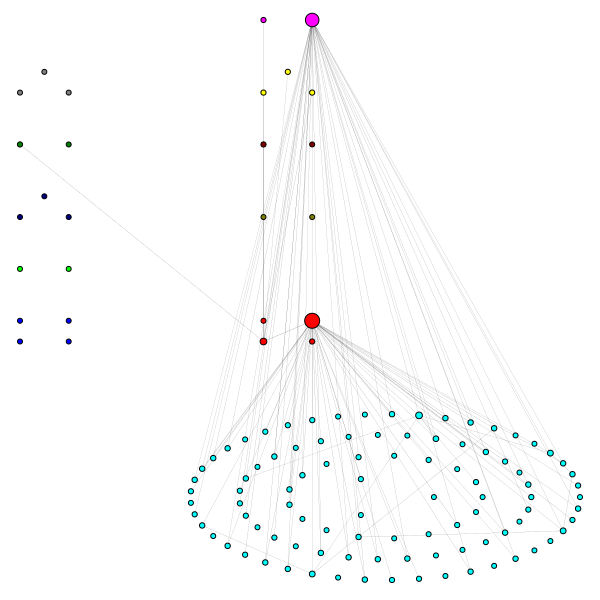

In [31]:
# extract the first 128 channels for M1 and ThaSMA areas
bandciCOH = ciCOH_beta1_mild[0:128, 0:128, :]

# delete the unused channels in weight
bandciCOH = np.delete(bandciCOH, idx_notused, axis=0)
bandciCOH = np.delete(bandciCOH, idx_notused, axis=1)


# save file config
savefilename = 'ciCOH_beta1_mild' + '.png'
savefile = os.path.join(savepath, savefilename)

# printed text config
texts = texts_area.copy()
title = 'Beta1 mild'
texts[title] = [300, 225, 25]

# visualize and save
igplot = bandciCOH_visual_save(bandciCOH, chn_area = chnInf_brainarea, 
                      chn_coord = chnInf_coord, lowweight = lowweight,  
                      savefile = savefile, texts = texts)

igplot.show()

print("Figure saved to " + savefile)

# del 
del bandciCOH, savefile, texts, title

### beta2

#### normal

In [38]:
# extract the first 128 channels for M1 and ThaSMA areas
bandciCOH = ciCOH_beta2_normal[0:128, 0:128, :]

# delete the unused channels in weight
bandciCOH = np.delete(bandciCOH, idx_notused, axis=0)
bandciCOH = np.delete(bandciCOH, idx_notused, axis=1)


# save file config
savefilename = 'ciCOH_beta2_normal' + '.png'
savefile = os.path.join(savepath, savefilename)

# printed text config
texts = texts_area.copy()
title = 'Beta2 normal'
texts[title] = [300, 225, 25]

# visualize and save
igplot = bandciCOH_visual_save(bandciCOH, chn_area = chnInf_brainarea, 
                      chn_coord = chnInf_coord, lowweight = lowweight,  
                      savefile = savefile, texts = texts)

igplot.show()

print("Figure saved to " + savefile)

# del 
del bandciCOH, savefile, texts, title

Figure saved to /home/lingling/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/pipeline/1_dataAnaly/FCAnaly/2_visual_FC_M1SMA/ciCOH_beta2_normal.png


#### mild

In [39]:
# extract the first 128 channels for M1 and ThaSMA areas
bandciCOH = ciCOH_beta2_mild[0:128, 0:128, :]

# delete the unused channels in weight
bandciCOH = np.delete(bandciCOH, idx_notused, axis=0)
bandciCOH = np.delete(bandciCOH, idx_notused, axis=1)


# save file config
savefilename = 'ciCOH_beta2_mild' + '.png'
savefile = os.path.join(savepath, savefilename)

# printed text config
texts = texts_area.copy()
title = 'Beta2 mild'
texts[title] = [300, 225, 25]

# visualize and save
igplot = bandciCOH_visual_save(bandciCOH, chn_area = chnInf_brainarea, 
                      chn_coord = chnInf_coord, lowweight = lowweight,  
                      savefile = savefile, texts = texts)
igplot.show()

print("Figure saved to " + savefile)

# del 
del bandciCOH, savefile, texts, title

Figure saved to /home/lingling/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/exp/pipeline/1_dataAnaly/FCAnaly/2_visual_FC_M1SMA/ciCOH_beta2_mild.png
